In [1]:
import numpy as np
import pandas as pd

from rdkit import RDLogger
from rdkit import Chem, rdBase
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PandasTools
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem.MolStandardize.standardize import canonicalize_tautomer_smiles
from rdkit.ML.Descriptors import MoleculeDescriptors


In [2]:
print(f'RDKit version: {rdBase.rdkitVersion}')

RDKit version: 2021.03.3


In [3]:
df_excel = pd.read_excel("./data/2019 Computational Investigation of Drug Phototoxicity - SI.xls")
df_excel.head()

,Substance,Canonical_Smiles,Set,PIF(collected),Rating,Value,Conditions,Literature
0,"2,3-Dehydrosilybin",COc1cc(ccc1O)C2Oc3cc(ccc3OC2CO)C4=C(O)C(=O)c5c...,Test,1.6,negative,0,3T3 Balb/c 2.5 J/cm2,"Journal of Photochemistry & Photobiology, B: B..."
1,ISB,COc1cc(ccc1O)[C@H]2Oc3ccc(cc3O[C@@H]2CO)[C@H]4...,Train,1,negative,0,3T3 Balb/c 2.5 J/cm2,"Journal of Photochemistry & Photobiology, B: B..."
2,SC,CO[C@H]1[C@@H](Oc2ccc(cc12)[C@H]3Oc4cc(O)cc(O)...,Train,1,negative,0,3T3 Balb/c 2.5 J/cm2,"Journal of Photochemistry & Photobiology, B: B..."
3,SD,COc1cc(ccc1O)C2[C@@H]3CO[C@@]4(O)C3C=C([C@H]5O...,Train,1,negative,0,3T3 Balb/c 2.5 J/cm2,"Journal of Photochemistry & Photobiology, B: B..."
4,SB,COc1cc(ccc1O)C2Oc3cc(ccc3OC2CO)[C@H]4Oc5cc(O)c...,Test,1,negative,0,3T3 Balb/c 2.5 J/cm2,"Journal of Photochemistry & Photobiology, B: B..."


In [4]:
def parent(smiles):
    '''Get parent of a smiles'''
    try:
        m = Chem.MolFromSmiles(smiles)
        if m is None:
            raise Exception("MolFromSmiles failed")
        m = rdMolStandardize.FragmentParent(m)
        return Chem.MolToSmiles(m)
    except:
        print(f"{smiles} failed conversion")
        return np.nan

def clean_smiles(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        Chem.SanitizeMol(mol)
        mol = Chem.RemoveHs(mol)
        mol = rdMolStandardize.MetalDisconnector().Disconnect(mol)
        mol = rdMolStandardize.Normalize(mol)
        mol = rdMolStandardize.Reionize(mol)
        Chem.AssignStereochemistry(mol, force=True, cleanIt=True)
        return Chem.MolToSmiles(mol)
    except:
        print(f"{smiles} failed conversion")
        return np.nan
    
def clean_data(data):
    '''Clean and standardize the data'''
    data = data.copy()
    
    # Remove missing smiles
    data = data[data['smiles'].notnull()]
    
    # Standardize and get parent
    data["smiles_parent"] = data['smiles'].apply(parent)
    
    # Remove rows with missing parent smiles
    data = data[data['smiles_parent'].notnull()]

    # Standardize parent smiles
    data["smiles_clean"] = data['smiles_parent'].apply(clean_smiles)
    
    # # Failed smiles
    # print(data.loc[data['smiles_clean'].isnull(), 'smiles'].values)

    # Remove rows with missing cleaned smiles
    data = data[data['smiles_clean'].notnull()]

    # Filter out small fragments
    def NumAtoms(smile):
        return Chem.MolFromSmiles(smile).GetNumAtoms()
    data["NumAtoms"] = data["smiles_clean"].apply(NumAtoms)
    data = data[data["NumAtoms"] > 3]
    data.drop(columns=['NumAtoms'],inplace = True)

    # Canonicalalize tautomer smiles
    # Attention: This step takes the longest time in data preparation
    data["Canonical_Smiles"] = data["smiles_clean"].apply(canonicalize_tautomer_smiles)
    # data["Canonical_Smiles"] = data["smiles_clean"]

    return data

data = df_excel.rename(columns={"Canonical_Smiles": "smiles"})
num_mols_before =  data.shape[0]

RDLogger.DisableLog('rdApp.info')
data = clean_data(data)
data.reset_index(drop=True, inplace=True)
RDLogger.EnableLog('rdApp.info')

num_mols_after =  data.shape[0]
print(f'#Molecules before cleaning: {num_mols_before}')
print(f'#Molecules  after cleaning: {num_mols_after}')


RDKit ERROR: [15:49:59] Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 6 7 12 13 16
RDKit ERROR: 
RDKit ERROR: [15:50:00] Explicit valence for atom # 14 N, 4, is greater than permitted
RDKit ERROR: [15:50:00] Explicit valence for atom # 14 N, 4, is greater than permitted
Cn1cc(c(OCc2ccc(cc2)C3=[N](C)C4C=CC=CC4=N3)n1)c5ccncc5 failed conversion
Cn1cc(c(OCc2ccc(cc2)C3=[N](C)C4N=CC=CC4=N3)n1)c5ccncc5 failed conversion
RDKit ERROR: [15:50:00] Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 6 7 12 13 16
RDKit ERROR: 
RDKit ERROR: [15:50:16] Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 6 7 12 13 16
RDKit ERROR: 
#Molecules before cleaning: 450
#Molecules  after cleaning: 447


In [5]:
# Keep required columns
keep = ["Substance", "Canonical_Smiles", "Rating", "Value"]
df_mols = data[keep].copy()

# Add molecules to dataframe
num_mols_before =  df_mols.shape[0]
PandasTools.AddMoleculeColumnToFrame(df_mols,'Canonical_Smiles','Molecule')

# Check for empty molecules
print("Failed conversion of smiles:")
print(df_mols[df_mols.Molecule.isnull()])

# Drop rows with empty molecules
df_mols = df_mols[df_mols.Molecule.notnull()]
df_mols.reset_index(drop=True, inplace=True)
num_mols_after =  df_mols.shape[0]

print(f'#Molecules before dropping: {num_mols_before}')
print(f'#Molecules  after dropping: {num_mols_after}')


Failed conversion of smiles:
Empty DataFrame
Columns: [Substance, Canonical_Smiles, Rating, Value, Molecule]
Index: []
#Molecules before dropping: 447
#Molecules  after dropping: 447


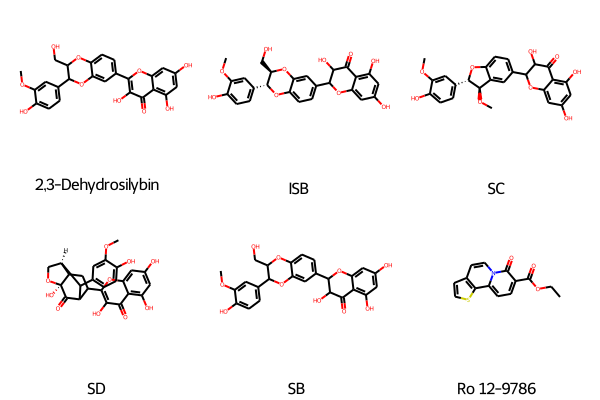

In [6]:
PandasTools.FrameToGridImage(df_mols[:6], column='Molecule', legendsCol='Substance')

In [7]:
# keep = ["Substance", "smiles", "Canonical_Smiles"]
# df_check = data[keep].copy()
# df_check.to_excel("./data/phototox_clean.xlsx", index=False)


In [8]:
nms = ['MinAbsPartialCharge', 'NumRadicalElectrons', 'HeavyAtomMolWt', 'MaxAbsEStateIndex', 'MaxAbsPartialCharge', 'MaxEStateIndex', 'MinPartialCharge', 'ExactMolWt', 'MolWt', 'NumValenceElectrons', 'MinEStateIndex', 'MinAbsEStateIndex',
       'MaxPartialCharge', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'HallKierAlpha', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1',
       'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3',
       'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA8', 'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA10', 'SlogP_VSA11', 'SlogP_VSA12', 'SlogP_VSA2', 'SlogP_VSA3', 'SlogP_VSA4', 'SlogP_VSA5', 'SlogP_VSA6', 'SlogP_VSA7', 'SlogP_VSA8',
       'SlogP_VSA9', 'TPSA', 'EState_VSA1', 'EState_VSA10', 'EState_VSA11', 'EState_VSA2', 'EState_VSA3', 'EState_VSA4', 'EState_VSA5', 'EState_VSA6', 'EState_VSA7', 'EState_VSA8', 'EState_VSA9', 'VSA_EState1', 'VSA_EState10',
       'VSA_EState2', 'VSA_EState3', 'VSA_EState4', 'VSA_EState5', 'VSA_EState6', 'VSA_EState7', 'VSA_EState8', 'VSA_EState9', 'FractionCSP3', 'HeavyAtomCount', 'NHOHCount', 'NOCount', 'NumAliphaticCarbocycles', 'NumAliphaticHeterocycles',
       'NumAliphaticRings', 'NumAromaticCarbocycles', 'NumAromaticHeterocycles', 'NumAromaticRings', 'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms', 'NumRotatableBonds', 'NumSaturatedCarbocycles', 'NumSaturatedHeterocycles',
       'NumSaturatedRings', 'RingCount', 'MolLogP', 'MolMR', 'fr_Al_COO', 'fr_Al_OH', 'fr_Al_OH_noTert', 'fr_ArN', 'fr_Ar_COO', 'fr_Ar_N', 'fr_Ar_NH', 'fr_Ar_OH', 'fr_COO', 'fr_COO2', 'fr_C_O', 'fr_C_O_noCOO', 'fr_C_S', 'fr_HOCCN',
       'fr_Imine', 'fr_NH0', 'fr_NH1', 'fr_NH2', 'fr_N_O', 'fr_Ndealkylation1', 'fr_Ndealkylation2', 'fr_Nhpyrrole', 'fr_SH', 'fr_aldehyde', 'fr_alkyl_carbamate', 'fr_alkyl_halide', 'fr_allylic_oxid', 'fr_amide', 'fr_amidine', 'fr_aniline',
       'fr_aryl_methyl', 'fr_azide', 'fr_azo', 'fr_barbitur', 'fr_benzene', 'fr_benzodiazepine', 'fr_bicyclic', 'fr_diazo', 'fr_dihydropyridine', 'fr_epoxide', 'fr_ester', 'fr_ether', 'fr_furan', 'fr_guanido', 'fr_halogen', 'fr_hdrzine',
       'fr_hdrzone', 'fr_imidazole', 'fr_imide', 'fr_isocyan', 'fr_isothiocyan', 'fr_ketone', 'fr_ketone_Topliss', 'fr_lactam', 'fr_lactone', 'fr_methoxy', 'fr_morpholine', 'fr_nitrile', 'fr_nitro', 'fr_nitro_arom',
       'fr_nitro_arom_nonortho', 'fr_nitroso', 'fr_oxazole', 'fr_oxime', 'fr_para_hydroxylation', 'fr_phenol', 'fr_phenol_noOrthoHbond', 'fr_phos_acid', 'fr_phos_ester', 'fr_piperdine', 'fr_piperzine', 'fr_priamide', 'fr_prisulfonamd',
       'fr_pyridine', 'fr_quatN', 'fr_sulfide', 'fr_sulfonamd', 'fr_sulfone', 'fr_term_acetylene', 'fr_tetrazole', 'fr_thiazole', 'fr_thiocyan', 'fr_thiophene', 'fr_unbrch_alkane', 'fr_urea']
rdkit_calculator = MoleculeDescriptors.MolecularDescriptorCalculator(nms)


def calc_rdkit_properties(mols):
    calc_desc = [rdkit_calculator.CalcDescriptors(mol) for mol in mols]
    calc_desc = np.asarray(calc_desc)
    calc_desc[~np.isfinite(calc_desc)] = 0
    return calc_desc, [f'RDKIT:{x}' for x in nms]


def calc_morgan_fingerprints(mols, nBits=1024, radius=3):    
    calc_fp = []
    for mol in mols:
        arr = np.zeros((1,))
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, useFeatures=True, nBits=nBits)
        DataStructs.ConvertToNumpyArray(fp, arr)
        calc_fp.append(arr)
    calc_fp = np.asarray(calc_fp)
    calc_fp[~np.isfinite(calc_fp)] = 0
    return calc_fp, [f'MORGANF_{radius}_{nBits}:{x}' for x in range(nBits)]

In [9]:
# Columns to keep from df_mols
keep = ["Substance", "Canonical_Smiles", "Rating", "Value"]

# Downcast binary Value to integer
df_mols["Value"] = df_mols["Value"].apply(pd.to_numeric, downcast='integer')

# Calculate rdkit features
rdkit_features, rdkit_columns = calc_rdkit_properties(df_mols['Molecule'])

df_rdkit = pd.DataFrame(data=rdkit_features, columns=rdkit_columns)
df_rdkit = df_mols[keep].join(df_rdkit)
print(f"df_rdkit: {df_rdkit.shape}")
df_rdkit.to_csv("./data/phototox_rdkit.csv", index=False)

# Calculate fingerprint features
fingerprint_features, fingerprint_columns = calc_morgan_fingerprints(df_mols['Molecule'], nBits=1024, radius=3)
df_fps = pd.DataFrame(data=fingerprint_features, columns=fingerprint_columns)
df_fps = df_mols[keep].join(df_fps)
df_fps[fingerprint_columns] = df_fps[fingerprint_columns].apply(pd.to_numeric, downcast='integer')
print(f"df_fps: {df_fps.shape}")
df_fps.to_csv("./data/phototox_fps.csv", index=False)

# Combine rdkit with fingerprint features
rdkit_fps_features = np.hstack([rdkit_features, fingerprint_features])
rdkit_fps_columns = np.hstack([rdkit_columns, fingerprint_columns])

df_rdkit_fps = pd.DataFrame(data=rdkit_fps_features, columns=rdkit_fps_columns)
df_rdkit_fps = df_mols[keep].join(df_rdkit_fps)
df_rdkit_fps[fingerprint_columns] = df_rdkit_fps[fingerprint_columns].apply(pd.to_numeric, downcast='integer')
print(f"df_rdkit_fps: {df_rdkit_fps.shape}")
df_rdkit_fps.to_csv("./data/phototox_rdkit_fps.csv", index=False)

df_rdkit: (447, 199)
df_fps: (447, 1028)
df_rdkit_fps: (447, 1223)
